In [1564]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch.optim import *
from functorch import vmap, grad
from IPython.display import display, clear_output
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import Module
from torch import  Tensor, tensor, zeros, softmax
from typing import Callable
from warnings import warn
from numpy import prod

%matplotlib inline

# The Model

In [1565]:
class Dense(nn.Module):
    def __init__(self, in_size: int, hidden_size: int):
        super().__init__()
        self.linear = nn.Linear(in_size, hidden_size)

    def forward(self, x: Tensor) -> Tensor:
        h = self.linear(x)
        return th.cat([x, h], dim=1)

In [1566]:
def differentiable_search(weights: Tensor,
                          prototypes: Tensor,
                          sample: Tensor,
                          temperature: Tensor | float = 1.,
                          epochs: int = 10,
                          step: float | Tensor = 0.01) -> tuple[Tensor, Tensor, Tensor]:
    # Shorten the names...
    w = weights
    Z = prototypes
    z = sample
    # Some sanity checks.
    assert w.shape[0] == Z.shape[0], f'w.shape[0] = {w.shape[0]} and Z.shape[0] = {Z.shape[0]} don\'t match.'
    assert len(w.shape) == 1, f'Weights should be a 1D tensor, instead got {w.shape}.'
    assert Z[0].shape == z.shape, f'Z[0].shape = {Z[0].shape} and z.shape = {z.shape} don\'t match.'
    if isinstance(step, Tensor):
        assert not step.shape, 'The step size must be a scalar tensor or a float.'
    # Now let's compute.
    norm = lambda w: softmax(w / temperature, dim=0)
    loss_fn = lambda w: F.mse_loss((norm(w).view(-1, 1) * Z).sum(dim=0), z)
    for epoch in range(epochs):
        w = w - step * grad(loss_fn)(w)
    return w, norm(w), loss_fn(w)

In [1567]:
class DifferentiableDB(Module):
    def __init__(self, prototypes: int, x_shape, y_shape, step: float, epochs: int):
        super().__init__()
        self.X = nn.Parameter(th.randn(prototypes, *x_shape))
        self.Y = nn.Parameter(th.randn(prototypes, *y_shape))
        self.step = nn.Parameter(tensor(step))
        self.epochs = epochs

    @property
    def prototypes(self):
        return self.X, self.Y

    @prototypes.setter
    def prototypes(self, pair: tuple[Tensor, Tensor]):
        self.X = nn.Parameter(pair[0])
        self.Y = nn.Parameter(pair[1])

    def _forward(self, x):
        w0 = zeros(self.X.shape[0])
        _, w1, _ = differentiable_search(w0, self.X, x, temperature=1., epochs=self.epochs, step=self.step)
        return (w1.view(-1, 1) * self.Y).sum(dim=0)

    def forward(self, X):
        return vmap(lambda x: self._forward(x))(X)

# The Problem

In [1568]:
def generate_data(f: Callable[[Tensor], Tensor], N: int, x_min: int = -1, x_max: int = 1) -> tuple[Tensor, Tensor]:
    X = th.rand(N, 1) * (x_max - x_min) + x_min
    Y = f(X)
    return X.detach(), Y.detach()

In [1569]:
x_min = 0.; x_max = 2.; resolution = 1000
fn = lambda x: 2 * x ** 3 - 5 * x ** 2 + 3 * x + 2 + th.sin(5 * x)
#fn = lambda x: th.sign(th.sin(2 * th.pi * x))
#fn = lambda x: x
training_samples = 10
X_training, Y_training = generate_data(fn, training_samples, x_min, x_max)

# Model Fitting

In [1570]:
def fit(model,
        X: Tensor,
        Y: Tensor,
        optim = Rprop,
        criterion: Callable[[Tensor, Tensor], Tensor] = F.mse_loss,
        epochs: int = 100,
        verbose=False):
    opt = optim(model.parameters())
    loss_fn = lambda: criterion(model(X), Y)
    model.train(mode=True)
    for epoch in range(epochs):
        opt.zero_grad()
        loss_fn().backward()
        opt.step()
        if verbose:
            with th.no_grad():
                clear_output(wait=True)
                print('Epoch %d | Loss: %.6f' % (epoch + 1, loss_fn()))
    model.train(mode=False)

In [1571]:
encoder = nn.Sequential(Dense(1, 9), nn.Mish(),
                        Dense(10, 10), nn.Mish(),
                        Dense(20, 20), nn.Mish(),
                        Dense(40, 40), nn.Mish(),
                        Dense(80, 80), nn.Mish())
model = nn.Sequential(encoder,
                      DifferentiableDB(training_samples * 2, (160,), Y_training.shape[1:], 0.1, 10))

In [1572]:
fit(model, X=X_training, Y=Y_training, epochs=200, verbose=True)

Epoch 200 | Loss: 0.000004


Test Loss: 0.008992
Training Loss: 0.000004


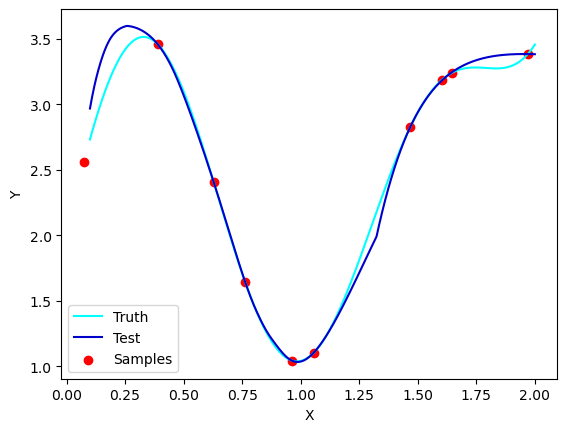

In [1576]:
# Sample ground truth.
X_truth = th.linspace(x_min + .1, x_max, resolution).view(-1, 1)
Y_truth = fn(X_truth)
# Sample predictions.
Y_pred = model(X_truth).detach()
# Plot everything.
plt.plot(X_truth.view(-1), Y_truth.view(-1), color='cyan', label='Truth')
plt.plot(X_truth.view(-1), Y_pred.view(-1), color='mediumblue', label='Test')
plt.scatter(X_training.view(-1), Y_training.view(-1), color='red', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
print('Test Loss: %.6f' % F.mse_loss(Y_pred, Y_truth))
print('Training Loss: %.6f' % F.mse_loss(model(X_training), Y_training))
plt.show()